In [1]:
from __future__ import division
import sys
import argparse
import numpy as np, matplotlib.pyplot as plt
import pretty_midi
import librosa
import itertools
from IPython.display import Audio,display

%matplotlib inline
#plt.rcParams['figure.figsize'] = (14,4)

Use Pretty MIDI to construct audio of combinations of three notes

In [10]:
# Create a PrettyMIDI object
cello_c_chord = pretty_midi.PrettyMIDI()
# Create an Instrument instance for a cello instrument
cello_program = pretty_midi.instrument_name_to_program('Cello')
cello = pretty_midi.Instrument(program=cello_program)
note_names = ['C5', 'E5', 'G5']
notes = [pretty_midi.note_name_to_number(note_name) for note_name in note_names]
# Iterate over note names, which will be converted to note number later
start = 0
for L in range(1,len(notes)+1):
    for subset in itertools.combinations(notes, L):
        print(subset)
        for note_number in subset:
            # Create a Note instance for this note, starting at 0s and ending at .5s
            note = pretty_midi.Note(velocity=100, pitch=note_number, start=start, end=start+.5)
            # Add it to our cello instrument
            cello.notes.append(note)
        start += .5
# Add the cello instrument to the PrettyMIDI object
cello_c_chord.instruments.append(cello)
# Write out the MIDI data
cello_audio = cello_c_chord.synthesize()
Audio(cello_audio,rate=44100)

(72,)
(76,)
(79,)
(72, 76)
(72, 79)
(76, 79)
(72, 76, 79)


Use Librosa to decompose audio and analyze

In [11]:
y = librosa.resample(cello_audio,44100,44100)
sr = 44100
n_components=3

In [12]:
S = librosa.stft(y,n_fft=8192*2)
W, H = librosa.decompose.decompose(np.abs(S), n_components=n_components,sort=True)
print W.shape
print H.shape

(8193, 3)
(3, 49)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


[199 190 198 191 197 192 196 193 195 194]
[240 249 241 248 242 247 243 246 244 245]
[243 287 295 288 294 289 293 290 292 291]


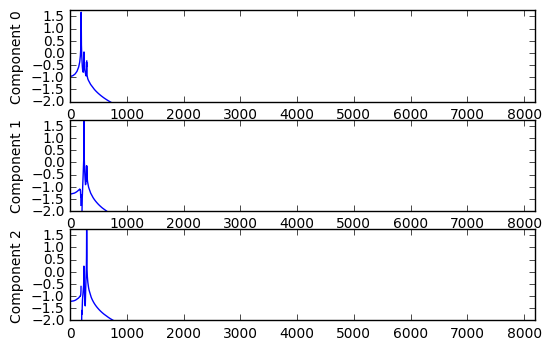

In [13]:
logW = np.log10(W)
for n in range(n_components):
    plt.subplot(n_components, 1, n+1)
    plt.plot(logW[:,n])
    plt.ylim(-2, logW.max())
    plt.xlim(0, W.shape[0])
    plt.ylabel('Component %d' % n)
    
    #10 highest peaks
    ind = np.argpartition(logW[:,n], -10)[-10:]
    ind = ind[np.argsort(logW[:,n][ind])]
    print(ind)

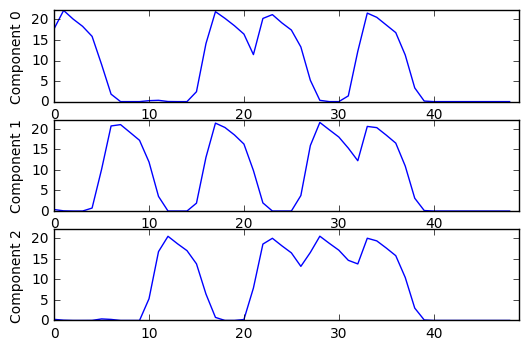

In [14]:
for n in range(n_components):
    plt.subplot(n_components, 1, n+1)
    plt.plot(H[n])
    plt.ylim(0, H.max())
    plt.xlim(0, H.shape[1])
    plt.ylabel('Component %d' % n)

In [19]:
reconstructed_signal = np.zeros(len(y))
for n in range(n_components):
    Ycomp = np.outer(W[:,n], H[n])*np.exp(1j*np.angle(S))
    ycomp = librosa.istft(Ycomp)
    reconstructed_signal[:len(ycomp)] += ycomp
    display(Audio(ycomp, rate=sr) )

In [20]:
Audio(reconstructed_signal, rate=sr)

In [21]:
residual = y - reconstructed_signal
residual[0] = 1 # hack to prevent automatic gain scaling
Audio(residual, rate=sr)